# Counterfactual Risk Minimisation (CRM)

In [1]:
# !pip install recogym torch
# !git clone https://github.com/criteo-research/bandit-reco.git

In [2]:
import os
# os.chdir('bandit-reco/notebooks')

%matplotlib inline

import gym 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from recogym.envs.session import OrganicSessions
from recogym import env_2_args, Configuration
from recogym import DefaultContext
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.evaluate_agent_sale import plot_verify_agents, verify_agents
from recogym.agents import FeatureProvider, OrganicUserEventCounterAgent, organic_user_count_args
from recogym.envs.utils_sale import *

from recogym.util import FullBatchLBFGS

# Set style for pretty plots
plt.style.use('ggplot')

P = 10  # Number of Products
U = 2000 # Number of Users

# You can overwrite environment arguments here:
env_2_args['random_seed'] = 42
env_2_args['num_products'] = P
env_2_args['number_of_flips'] = P//2
env_2_args['sigma_mu_organic'] = 3
env_2_args['sigma_omega'] = 0.1

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v2')
env.init_gym(env_2_args)
env.reset()

## Data generation


We generate data with a popularity agent plus some randomness for exploration (`epsilon`).


In [3]:
# Generate RecoGym logs for U users
logger = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                     'select_randomly': True,
                                                     'random_seed': 1221, # 1220
                                                     'epsilon': 0.001}))
reco_log = env.generate_logs(U, agent = logger)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:10<00:00, 15.37it/s]


Let's have a quick look at the logs

In [4]:
reco_log.head(5)

,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,1,<NA>,NaN,NaN,NaN,None
1,1.0,0,organic,4,<NA>,NaN,NaN,NaN,None
2,2.0,0,bandit,<NA>,4,0.0,0.0,0.4995,()
3,3.0,0,bandit,<NA>,4,0.0,0.0,0.4995,()
4,4.0,0,organic,6,<NA>,NaN,NaN,NaN,None


In [5]:
reco_log["z"].unique()

array(['organic', 'bandit', 'sale'], dtype=object)

We will use the popularity agent as the baseline. It basically predict the organic product that has been seen the most so far by the user. It is a simple but actually strong baseline.

In [6]:
organic_counter_agent = OrganicUserEventCounterAgent(
    Configuration({**organic_user_count_args, 'select_randomly': False, 'exploit_explore': False, 'epsilon': 0.0}))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:25<00:00, 24.29it/s]


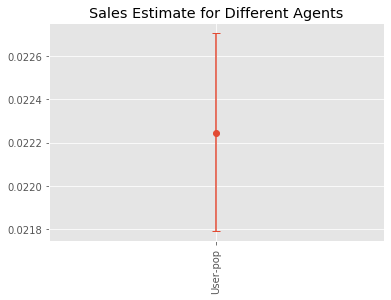

In [7]:
N_USERS_AB_TEST = 5000
result_AB = verify_agents(env, N_USERS_AB_TEST, {'User-pop': organic_counter_agent})
plot_verify_agents(result_AB)
None

## Contextual Bandits

### Data set transformation

In order to feed logs to a model, we need to transform them such that we have a dataset consisting in sequences of user context $x$, taken action $a$, reward $c$ and propensity scores $p$.

In [8]:
class ProductCountFeatureProvider(FeatureProvider):
    """This feature provider creates a user state based on viewed product count.
    Namely, the feature vector of shape (n_products, ) contains for each product how many times the
    user has viewed them organically.
    """

    def __init__(self, config):
        super(ProductCountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products)).astype(int)

    def observe(self, observation):
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        return self.feature_data.copy()

    def reset(self):
        self.feature_data[:] = 0


def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if (row['z'] == 'organic') or (row['z'] == 'sale'):
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['r']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

Let's build and dissect this so-called rectangular dataset

In [9]:
# You can now see data that will be provided to our agents based on logistic regressions
count_product_views_feature_provider = ProductCountFeatureProvider(config=Configuration(env_2_args))

In [10]:
rectangular_logs = build_rectangular_data(reco_log, count_product_views_feature_provider)
user_states, actions, rewards, proba_actions = rectangular_logs

In [11]:
preview_start, preview_size = 300, 5

print('user product views count at action time')
print(user_states[preview_start:preview_start + preview_size])
print('taken actions', actions[preview_start:preview_start + preview_size])
print('obtained rewards', rewards[preview_start:preview_start + preview_size])
print('probablities of the taken actions', proba_actions[preview_start:preview_start + preview_size])

user product views count at action time
[[0 0 0 0 5 1 0 0 0 5]
 [0 0 0 0 5 1 0 0 0 5]
 [0 0 0 0 5 1 0 0 0 5]
 [0 0 0 0 5 1 0 0 0 5]
 [0 0 0 0 5 1 0 0 0 5]]
taken actions [4 4 4 9 4]
obtained rewards [0. 0. 0. 0. 0.]
probablities of the taken actions [0.45409091 0.45409091 0.45409091 0.45409091 0.45409091]


### Vanilla contextual bandit

Classical value-based methods aim to learn the probability that a given action will lead to a positive reward, that is:

$$p(c = 1|\mathbf{x},a)$$

In what follows, we will implement a different approach: a policy learning method.
Policy-learning methods do not explicitly model the probability of a positive reward, but aim to directly model the action that should be taken, given a context:

$$p(a|\mathbf{x})$$

Classical contextual bandits achieve this by optimising the expectation of the reward under the new (learned) policy $\pi_\theta$, given a logged dataset under policy $\pi_0$.
For a given dataset $\mathcal{D}$ consisting of $N$ tuples $(\mathbf{x},a,p,c)$, the objective can be written as the following:

$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)}$$

This objective can be straightforwardly optimised using your favourite package that provides auto-differentiation functionality.
In our example, we will use PyTorch.

In [12]:
class MultinomialLogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        # Generate weights - initialise randomly
        self.weight = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        # torch.nn.init.kaiming_uniform_(self.weight, a = np.sqrt(5))
        torch.nn.init.zeros_(self.weight)

    def forward(self, x):
        inner_product = F.linear(x, self.weight)
        return F.softmax(inner_product, dim = 1)

class VanillaContextualBandit(Agent):
    def __init__(self, config, U = U, P = P, clipping_value = 1e5, max_epoch=30):
        Agent.__init__(self, config)
        self.model = MultinomialLogisticRegressionModel(P, P)
        self.loss_history = []
        self.user_state = np.zeros(P)
        self.U = U
        self.P = P
        self.max_epoch = max_epoch
        self.clipping_value = clipping_value

    def loss(self, X, a, proba_logged_actions, r):
        # Compute action predictions for clicks
        predicted_proba_for_all_actions = self.model(X)
        
        # Only keep probabilities for the actions that were taken
        predicted_proba = torch.gather(predicted_proba_for_all_actions, 1, a.unsqueeze(1)).reshape(-1)
        
        # expectation of the rewards under the new policy
        rewards = predicted_proba / proba_logged_actions
        
        # code here
        # We can cap the weights here (or equivalently the rewards in our case)
        # to some value of our choosing
        rewards = torch.clamp(input = rewards, max = self.clipping_value)
        
        # Since pytorch is meant to perform convex optimization, we rather
        # output a loss that we will want to minimize
        loss = - rewards.mean()
        return loss

    def train(self, rectangular_logs):
        """Train the contextual bandit based on an offline log such that it 
        learns to minimize its loss function
        """
        user_states, actions, rewards, proba_actions = rectangular_logs
        X = user_states
        a = actions
        p = proba_actions
        r = rewards
        
        # Put into PyTorch variables - drop unsaled samples
        X = Variable(torch.Tensor(X[r != 0]))
        a = Variable(torch.LongTensor(a[r != 0]))
        w = torch.Tensor(p[r != 0])
        
        def closure():
            # Reset gradients
            optimiser.zero_grad()

            return self.loss(X, a, w, r)
        
        # Set up optimiser
        optimiser = FullBatchLBFGS(self.model.parameters())

        # Initial loss
        self.loss_history.append(closure())
        max_epoch = self.max_epoch
        for epoch in range(max_epoch):
            # Optimisation step
            obj, _, _, _, _, _, _, _ = optimiser.step({'closure': closure,
                                                       'current_loss': self.loss_history[-1],
                                                       'max_ls': 20})
            self.loss_history.append(obj)
        
        return

    def plot_loss_history(self):
        ''' Plot the training loss over epochs '''
        _,_ = plt.subplots()
        plt.plot(range(len(self.loss_history)),self.loss_history)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        
    def observe(self, observation):
        ''' Observe new organic views and capture them in the user state '''
        for session in observation.sessions():
            self.user_state[int(session['v'])] += 1

    def act(self, observation, reward, done):
        ''' Pick an action, based on the current observation and the history '''
        # Observe
        self.observe(observation)

        # Act
        p_a = self.model(torch.Tensor([self.user_state])).detach().numpy().ravel()
        action = np.argmax(p_a)
        prob = np.zeros_like(p_a)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1.0,
                'ps-a': prob,
            },
        }

    def reset(self):
        ''' Reset the user state '''
        self.user_state = np.zeros(self.P)

In [13]:
vanilla_cb = VanillaContextualBandit({}, max_epoch=100)
vanilla_cb.train(rectangular_logs)

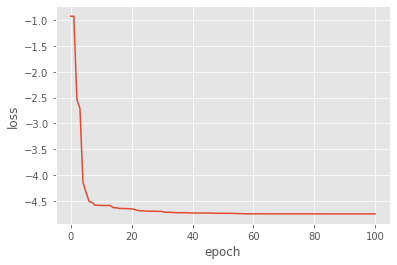

In [14]:
vanilla_cb.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [04:48<00:00, 17.33it/s]


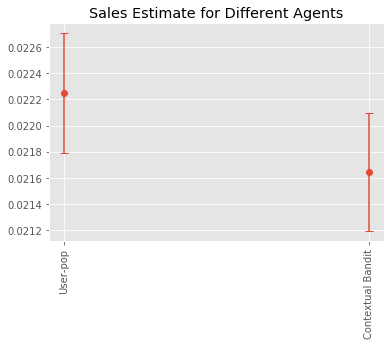

In [15]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Contextual Bandit': vanilla_cb})])
plot_verify_agents(result_AB)
None

It appears that some clicked events were actually sampled with a small probability ($\pi_0 \ll 1$). This might lead to overfitting for the contextual bandit and bad online performances.

In [16]:
(reco_log[reco_log['r'] > 0]).sort_values('ps').head(5)

,t,u,z,v,a,c,r,ps,ps-a
6549,38.0,68,bandit,<NA>,2,1.0,1.0,0.000143,()
59856,16.0,533,bandit,<NA>,8,0.0,1.0,0.000143,()
49955,34.0,440,bandit,<NA>,6,0.0,1.0,0.000200,()
48633,441.0,428,bandit,<NA>,5,1.0,1.0,0.008056,()
60342,296.0,535,bandit,<NA>,8,0.0,1.0,0.010628,()


## Log Contextual Bandit

In [17]:
class LogContextualBandit(VanillaContextualBandit):

    def loss(self, X, a, proba_logged_actions, r):
        # Compute action predictions for sales
        predicted_proba_for_all_actions = self.model(X)
        
        # Only keep probabilities for the actions that were taken
        predicted_proba = torch.gather(predicted_proba_for_all_actions, 1, a.unsqueeze(1)).reshape(-1)
        
        # expectation of the reward under the new policy
        # code here
        reward = predicted_proba / proba_logged_actions
        
        loss = -reward

        return loss.mean()

In [18]:
log_cb = LogContextualBandit({}, max_epoch=200)
log_cb.train(rectangular_logs)

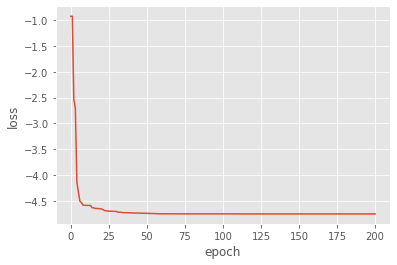

In [19]:
log_cb.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [04:10<00:00, 19.98it/s]


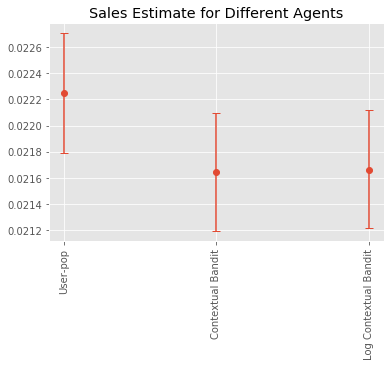

In [20]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Log Contextual Bandit': log_cb})])
plot_verify_agents(result_AB)
None

## POEM

The classical IPS estimator has its disadvantages, however.
In its current form, the variance of the estimate can grow to be of significant size.
To mitigate this, Swaminathan and Joachims propose to include a sample variance penalisation term to the objective, effectively ensuring that the learned model does not stray too far from the logging policy.

This is the Counterfactual Risk Minimisation (CRM) objective, and the learning method optimising it directly is called POEM:
$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)} - \lambda \sqrt{\frac{\widehat{Var}_\theta}{N}} $$


We model $\pi_\theta$ as linear:

$$\pi_\theta(a|\mathbf{x}) = \text{softmax}(\mathbf{x}^{\intercal}\theta)_a$$


Swaminathan, Adith, and Thorsten Joachims. "Batch learning from logged bandit feedback through counterfactual risk minimization." Journal of Machine Learning Research 16.1 (2015): 1731-1755.

In [21]:
class PoemContextualBandit(VanillaContextualBandit):
    def __init__(self, config, U = U, P = P, max_epoch=30, variance_penalization_factor=0.):
        VanillaContextualBandit.__init__(self, config, U=U, P=P, max_epoch=max_epoch)
        self.variance_penalization_factor = variance_penalization_factor

    def loss(self, X, a, proba_logged_actions, r):
        # Compute action predictions for clicks
        predicted_proba_for_all_actions = self.model(X)
        
        # Only keep probabilities for the actions that were taken
        predicted_proba = torch.gather(predicted_proba_for_all_actions, 1, a.unsqueeze(1)).reshape(-1)
        
        # expectation of the loss under the new policy
        # code here
        # Note: have a look at torch.sqrt and torch.var
        reward = predicted_proba / proba_logged_actions
        loss = - reward.mean() + self.variance_penalization_factor*torch.sqrt(torch.var(reward)/predicted_proba.size()[0])
        return loss


In [22]:
poem = PoemContextualBandit({}, variance_penalization_factor=0.4, max_epoch=100)
poem.train(rectangular_logs)

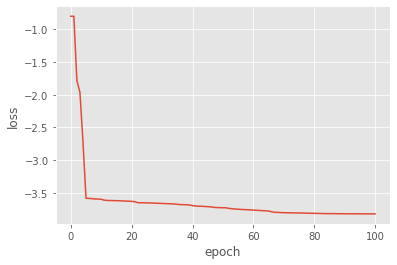

In [23]:
poem.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:42<00:00, 22.45it/s]


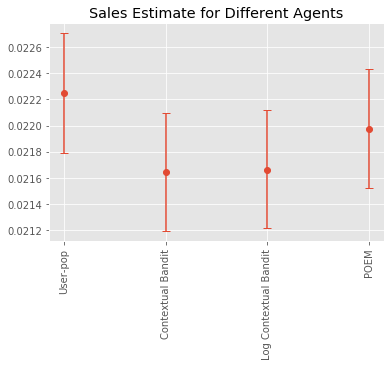

In [24]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {f'POEM': poem})])
plot_verify_agents(result_AB)
None

In [25]:
result_AB

,Agent,0.025,0.500,0.975
0,User-pop,0.021790,0.022246,0.022707
0,Contextual Bandit,0.021192,0.021640,0.022094
0,Log Contextual Bandit,0.021213,0.021662,0.022116
0,POEM,0.021522,0.021974,0.022433
